In [1]:
"""
MLB First-Pitch Psychology Data Collection
============================================
This script collects pitch-by-pitch data from MLB Statcast to analyze
how first-pitch outcomes (strike vs. ball) affect at-bat results.

Author: Walter Vogelmann
Date: November 2025
Question: How do outcomes differ when pitchers throw a strike vs. ball 
         on the first pitch, controlling for batter aggression?
"""

import pandas as pd
import numpy as np
from pybaseball import statcast, cache
import warnings
warnings.filterwarnings('ignore')

# Enable caching to save time on repeated queries
cache.enable()

In [2]:
# STEP 1: Define Data Collection Parameters

# Data from the 2024 season
# Adjust these dates based on your needs
START_DATE = '2024-04-01'  # Start of 2024 season
END_DATE = '2024-09-30'    # End of regular season

print(f"Collecting Statcast data from {START_DATE} to {END_DATE}")

In [3]:
# STEP 2: Collect Raw Statcast Data

def collect_statcast_data(start_dt, end_dt):
    """
    Collect pitch-by-pitch Statcast data for specified date range.
    
    Parameters:
    -----------
    start_dt : str
        Start date in 'YYYY-MM-DD' format
    end_dt : str
        End date in 'YYYY-MM-DD' format
    
    Returns:
    --------
    pd.DataFrame : Raw Statcast data
    """
    try:
        data = statcast(start_dt=start_dt, end_dt=end_dt)
        print(f"Successfully collected {len(data):,} pitches")
        return data
    except Exception as e:
        print(f"Error collecting data: {e}")
        return None

# Collect the data
raw_data = collect_statcast_data(START_DATE, END_DATE)

This is a large query, it may take a moment to complete


100%|██████████| 183/183 [00:03<00:00, 55.36it/s]


Successfully collected 695,264 pitches


In [4]:
# STEP 3: Filter for First Pitches Only

def identify_first_pitches(df):
    """
    Filter dataset to include only first pitches of each at-bat.
    
    The pitch_number column indicates the pitch number within an at-bat.
    pitch_number == 1 means it's the first pitch.
    """
    first_pitches = df[df['pitch_number'] == 1].copy()
    print(f"\nFiltered to {len(first_pitches):,} first pitches")
    return first_pitches

first_pitch_data = identify_first_pitches(raw_data)


Filtered to 178,604 first pitches


In [5]:
# STEP 4: Create First-Pitch Outcome Variable

def classify_first_pitch_outcome(df):
    """
    Classify whether the first pitch was a strike or ball.
    
    Uses the 'type' column where:
    - 'S' = strike (including swinging strikes, called strikes, foul balls)
    - 'B' = ball
    - 'X' = ball in play (we'll treat as strike since batter made contact)
    """
    df['first_pitch_outcome'] = df['type'].map({
        'S': 'Strike',
        'B': 'Ball',
        'X': 'Strike'  # Ball in play counts as competitive pitch
    })
    
    # Remove any rows where type is null or unexpected
    df = df[df['first_pitch_outcome'].notna()].copy()
    
    print(f"\nFirst-pitch outcome distribution:")
    print(df['first_pitch_outcome'].value_counts())
    print(f"Percentage strikes: {(df['first_pitch_outcome']=='Strike').mean()*100:.1f}%")
    
    return df

first_pitch_data = classify_first_pitch_outcome(first_pitch_data)


First-pitch outcome distribution:
first_pitch_outcome
Strike    111318
Ball       67286
Name: count, dtype: int64
Percentage strikes: 62.3%


In [6]:
# STEP 5: Extract At-Bat Outcomes

def extract_at_bat_outcomes(df):
    """
    Extract and categorize the final outcome of each at-bat.
    
    The 'events' column contains the at-bat result, but only on the 
    final pitch. We need to merge this with our first-pitch data.
    """
    # The 'events' column shows the at-bat outcome
    # Create simplified outcome categories
    def categorize_outcome(event):
        if pd.isna(event):
            return 'In_Progress'  # At-bat didn't end on this pitch
        elif event in ['single', 'double', 'triple', 'home_run']:
            return 'Hit'
        elif event in ['walk', 'hit_by_pitch', 'intent_walk']:
            return 'Walk'
        elif event in ['strikeout', 'strikeout_double_play']:
            return 'Strikeout'
        elif 'out' in event or event in ['field_error', 'fielders_choice',
                                          'force_out', 'grounded_into_double_play',
                                          'sac_fly', 'sac_bunt']:
            return 'Out'
        else:
            return 'Other'
    
    df['at_bat_outcome'] = df['events'].apply(categorize_outcome)
    
    return df

# First we need to get the at-bat outcomes
# We'll use game_pk and at_bat_number to merge outcomes
print("\nMatching first pitches with at-bat outcomes...")

# Get all final pitches (which have the at-bat outcome)
at_bat_outcomes = raw_data[raw_data['events'].notna()][
    ['game_pk', 'at_bat_number', 'events', 'batter', 'pitcher']
].copy()

# Merge at-bat outcomes with first-pitch data
first_pitch_data = first_pitch_data.merge(
    at_bat_outcomes[['game_pk', 'at_bat_number', 'events']],
    on=['game_pk', 'at_bat_number'],
    how='left',
    suffixes=('', '_final')
)

# Use the final events column
first_pitch_data['events'] = first_pitch_data['events_final'].fillna(first_pitch_data['events'])
first_pitch_data = first_pitch_data.drop('events_final', axis=1)

first_pitch_data = extract_at_bat_outcomes(first_pitch_data)


Matching first pitches with at-bat outcomes...


In [7]:
# STEP 6: Calculate Batter Aggression Metrics

def calculate_batter_aggression(raw_df, first_pitch_df):
    """
    Calculate batter aggression metrics:
    - Overall swing rate
    - Chase rate (swings at pitches outside zone)
    - First-pitch swing rate
    
    These will be used as control variables.
    """
    print("\nCalculating batter aggression metrics...")
    
    # Calculate swing rate per batter
    # description field contains info about whether batter swung
    swing_descriptions = [
        'swinging_strike', 'swinging_strike_blocked', 'foul', 
        'foul_tip', 'hit_into_play', 'foul_bunt', 'missed_bunt'
    ]
    
    raw_df['is_swing'] = raw_df['description'].isin(swing_descriptions)
    
    # Calculate per-batter metrics
    batter_metrics = raw_df.groupby('batter').agg({
        'is_swing': 'mean',  # Overall swing rate
        'pitch_number': 'count'  # Total pitches seen
    }).rename(columns={
        'is_swing': 'swing_rate',
        'pitch_number': 'pitches_seen'
    })
    
    # Calculate chase rate (swings outside zone)
    # Zone numbers 11-14 are outside the strike zone
    outside_zone = raw_df['zone'].isin([11, 12, 13, 14])
    chase_rate = raw_df[outside_zone].groupby('batter')['is_swing'].mean()
    batter_metrics['chase_rate'] = chase_rate
    
    # Calculate first-pitch swing rate specifically
    first_pitch_swings = raw_df[raw_df['pitch_number'] == 1].groupby('batter')['is_swing'].mean()
    batter_metrics['first_pitch_swing_rate'] = first_pitch_swings
    
    # Merge with first-pitch data
    first_pitch_df = first_pitch_df.merge(
        batter_metrics,
        left_on='batter',
        right_index=True,
        how='left'
    )
    
    print(f"Added aggression metrics for {len(batter_metrics)} unique batters")
    
    return first_pitch_df

first_pitch_data = calculate_batter_aggression(raw_data, first_pitch_data)


Calculating batter aggression metrics...
Added aggression metrics for 651 unique batters


In [8]:
# STEP 7: Select and Clean Final Variables

def select_final_variables(df):
    """
    Select the most relevant variables for analysis and handle missing values.
    """
    # Core variables we want to keep
    keep_cols = [
        # Identifiers
        'game_pk', 'game_date', 'at_bat_number', 'batter', 'pitcher',
        
        # First pitch characteristics
        'first_pitch_outcome', 'pitch_type', 'release_speed', 
        'pfx_x', 'pfx_z',  # Pitch movement
        'plate_x', 'plate_z',  # Pitch location
        
        # Count context
        'balls', 'strikes', 'outs_when_up', 'inning',
        
        # Outcome variable
        'at_bat_outcome',
        
        # Batter aggression (control variables)
        'swing_rate', 'chase_rate', 'first_pitch_swing_rate',
        'pitches_seen',
        
        # Additional context
        'stand', 'p_throws', 'home_team', 'away_team'
    ]
    
    # Keep only columns that exist
    available_cols = [col for col in keep_cols if col in df.columns]
    df_clean = df[available_cols].copy()
    
    # Remove rows with missing critical variables
    df_clean = df_clean.dropna(subset=[
        'first_pitch_outcome', 'at_bat_outcome', 
        'swing_rate', 'first_pitch_swing_rate'
    ])
    
    print(f"\nFinal dataset: {len(df_clean):,} at-bats")
    print(f"Number of variables: {len(df_clean.columns)}")
    
    return df_clean

final_data = select_final_variables(first_pitch_data)


Final dataset: 178,604 at-bats
Number of variables: 25


In [9]:
# STEP 8: Generate Summary Statistics

def generate_summary_stats(df):
    """
    Generate summary statistics for the blog post.
    """
    print("\n" + "="*60)
    print("DATASET SUMMARY STATISTICS")
    print("="*60)
    
    print(f"\nTotal at-bats: {len(df):,}")
    print(f"Date range: {df['game_date'].min()} to {df['game_date'].max()}")
    print(f"Unique batters: {df['batter'].nunique():,}")
    print(f"Unique pitchers: {df['pitcher'].nunique():,}")
    
    print("\n--- First-Pitch Outcomes ---")
    print(df['first_pitch_outcome'].value_counts())
    print(f"\nStrike percentage: {(df['first_pitch_outcome']=='Strike').mean()*100:.1f}%")
    
    print("\n--- At-Bat Outcomes ---")
    print(df['at_bat_outcome'].value_counts())
    
    print("\n--- Batter Aggression Metrics (Mean) ---")
    print(f"Overall swing rate: {df['swing_rate'].mean():.3f}")
    print(f"Chase rate: {df['chase_rate'].mean():.3f}")
    print(f"First-pitch swing rate: {df['first_pitch_swing_rate'].mean():.3f}")
    
    # Cross-tabulation: first pitch outcome vs at-bat outcome
    print("\n--- Success Rate by First-Pitch Outcome ---")
    crosstab = pd.crosstab(
        df['first_pitch_outcome'], 
        df['at_bat_outcome'], 
        normalize='index'
    ) * 100
    print(crosstab.round(1))
    
    return df

final_data = generate_summary_stats(final_data)


DATASET SUMMARY STATISTICS

Total at-bats: 178,604
Date range: 2024-04-01 00:00:00 to 2024-09-30 00:00:00
Unique batters: 651
Unique pitchers: 853

--- First-Pitch Outcomes ---
first_pitch_outcome
Strike    111318
Ball       67286
Name: count, dtype: int64

Strike percentage: 62.3%

--- At-Bat Outcomes ---
at_bat_outcome
Out            82152
Strikeout      40213
Hit            38870
Walk           16510
Other            755
In_Progress      104
Name: count, dtype: int64

--- Batter Aggression Metrics (Mean) ---
Overall swing rate: 0.480
Chase rate: 0.286
First-pitch swing rate: 0.320

--- Success Rate by First-Pitch Outcome ---
at_bat_outcome        Hit  In_Progress  Other   Out  Strikeout  Walk
first_pitch_outcome                                                 
Ball                 21.1          0.1    0.5  43.6       18.5  16.3
Strike               22.2          0.1    0.4  47.4       24.9   5.0


In [10]:
# STEP 9: Save the Dataset

def save_dataset(df, filename='mlb_first_pitch_data_2024.csv'):
    """
    Save the final dataset to CSV.
    """
    df.to_csv(filename, index=False)
    print(f"\n✓ Dataset saved to {filename}")
    print(f"  Size: {len(df):,} rows × {len(df.columns)} columns")
    
save_dataset(final_data)

print("\n" + "="*60)
print("DATA COLLECTION COMPLETE!")
print("="*60)
print("\nNext steps:")
print("1. Perform exploratory data analysis (visualizations)")
print("2. Run statistical tests (t-tests, chi-square)")
print("3. Build regression models controlling for batter aggression")
print("4. Write your blog post!")


✓ Dataset saved to mlb_first_pitch_data_2024.csv
  Size: 178,604 rows × 25 columns

DATA COLLECTION COMPLETE!

Next steps:
1. Perform exploratory data analysis (visualizations)
2. Run statistical tests (t-tests, chi-square)
3. Build regression models controlling for batter aggression
4. Write your blog post!


In [11]:
"""
First-Pitch Psychology - Exploratory Data Analysis
===================================================
This script performs EDA on the first-pitch dataset to answer:
"How do outcomes differ when pitchers throw a strike vs. ball on the first pitch?"

Run this AFTER you've collected the data using the collection script.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# STEP 1: Load the Data

print("Loading data...")
df = pd.read_csv('mlb_first_pitch_data_2024.csv')
print(f"Loaded {len(df):,} at-bats\n")

Loading data...
Loaded 178,604 at-bats



In [12]:
# STEP 2: Compare Outcomes by First-Pitch Type

print("="*60)
print("ANALYSIS 1: At-Bat Outcomes by First-Pitch Type")
print("="*60)

# Calculate success rates
outcome_by_pitch = pd.crosstab(
    df['first_pitch_outcome'], 
    df['at_bat_outcome'],
    normalize='index'
) * 100

print("\nPercentage of each outcome by first-pitch type:")
print(outcome_by_pitch.round(1))

# Focus on key outcomes
for outcome in ['Hit', 'Walk', 'Strikeout']:
    if outcome in outcome_by_pitch.columns:
        strike_rate = outcome_by_pitch.loc['Strike', outcome]
        ball_rate = outcome_by_pitch.loc['Ball', outcome]
        diff = strike_rate - ball_rate
        print(f"\n{outcome}:")
        print(f"  After first-pitch strike: {strike_rate:.1f}%")
        print(f"  After first-pitch ball: {ball_rate:.1f}%")
        print(f"  Difference: {diff:+.1f} percentage points")

ANALYSIS 1: At-Bat Outcomes by First-Pitch Type

Percentage of each outcome by first-pitch type:
at_bat_outcome        Hit  In_Progress  Other   Out  Strikeout  Walk
first_pitch_outcome                                                 
Ball                 21.1          0.1    0.5  43.6       18.5  16.3
Strike               22.2          0.1    0.4  47.4       24.9   5.0

Hit:
  After first-pitch strike: 22.2%
  After first-pitch ball: 21.1%
  Difference: +1.1 percentage points

Walk:
  After first-pitch strike: 5.0%
  After first-pitch ball: 16.3%
  Difference: -11.3 percentage points

Strikeout:
  After first-pitch strike: 24.9%
  After first-pitch ball: 18.5%
  Difference: +6.4 percentage points


In [13]:
# STEP 3: Statistical Tests

print("\n" + "="*60)
print("ANALYSIS 2: Statistical Significance Tests")
print("="*60)

# Chi-square test: Are outcomes independent of first-pitch type?
contingency_table = pd.crosstab(
    df['first_pitch_outcome'], 
    df['at_bat_outcome']
)
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\nChi-square test for independence:")
print(f"  Chi-square statistic: {chi2:.2f}")
print(f"  P-value: {p_value:.4f}")
print(f"  Degrees of freedom: {dof}")
if p_value < 0.05:
    print("  ✓ Result: SIGNIFICANT relationship (p < 0.05)")
else:
    print("  ✗ Result: No significant relationship")


ANALYSIS 2: Statistical Significance Tests

Chi-square test for independence:
  Chi-square statistic: 6706.91
  P-value: 0.0000
  Degrees of freedom: 5
  ✓ Result: SIGNIFICANT relationship (p < 0.05)


In [14]:
# STEP 4: Control for Batter Aggression

print("\n" + "="*60)
print("ANALYSIS 3: Controlling for Batter Aggression")
print("="*60)

# Divide batters into aggression groups
df['aggression_group'] = pd.qcut(
    df['first_pitch_swing_rate'], 
    q=3, 
    labels=['Passive', 'Moderate', 'Aggressive']
)

print("\nBatter aggression groups (by first-pitch swing rate):")
print(df['aggression_group'].value_counts().sort_index())

# Analyze within each aggression group
print("\n--- Success Rates by Aggression Level ---")
for aggression in ['Passive', 'Moderate', 'Aggressive']:
    subset = df[df['aggression_group'] == aggression]
    
    strike_hits = subset[subset['first_pitch_outcome'] == 'Strike']['at_bat_outcome'].eq('Hit').mean()
    ball_hits = subset[subset['first_pitch_outcome'] == 'Ball']['at_bat_outcome'].eq('Hit').mean()
    
    print(f"\n{aggression} batters (n={len(subset):,}):")
    print(f"  Hit rate after strike: {strike_hits*100:.1f}%")
    print(f"  Hit rate after ball: {ball_hits*100:.1f}%")
    print(f"  Difference: {(strike_hits - ball_hits)*100:+.1f} pp")


ANALYSIS 3: Controlling for Batter Aggression

Batter aggression groups (by first-pitch swing rate):
aggression_group
Passive       59989
Moderate      59106
Aggressive    59509
Name: count, dtype: int64

--- Success Rates by Aggression Level ---

Passive batters (n=59,989):
  Hit rate after strike: 22.0%
  Hit rate after ball: 21.1%
  Difference: +0.9 pp

Moderate batters (n=59,106):
  Hit rate after strike: 22.4%
  Hit rate after ball: 20.9%
  Difference: +1.4 pp

Aggressive batters (n=59,509):
  Hit rate after strike: 22.2%
  Hit rate after ball: 21.2%
  Difference: +1.0 pp



Creating visualizations...
✓ Saved: first_pitch_outcomes.png
✓ Saved: aggression_controlled_analysis.png
✓ Saved: pitch_location_heatmap.png


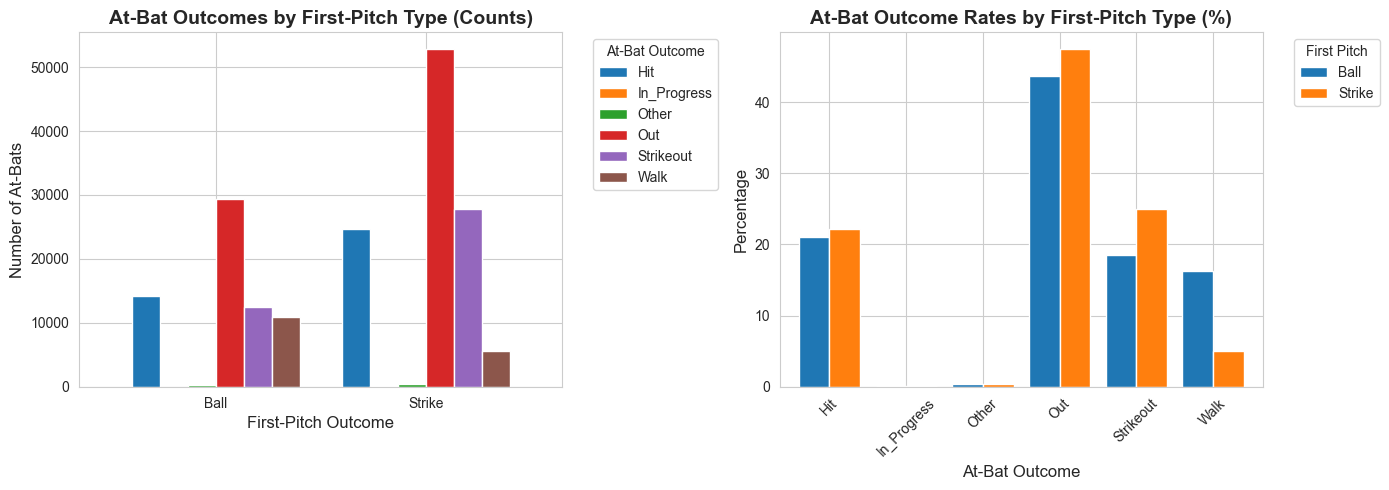

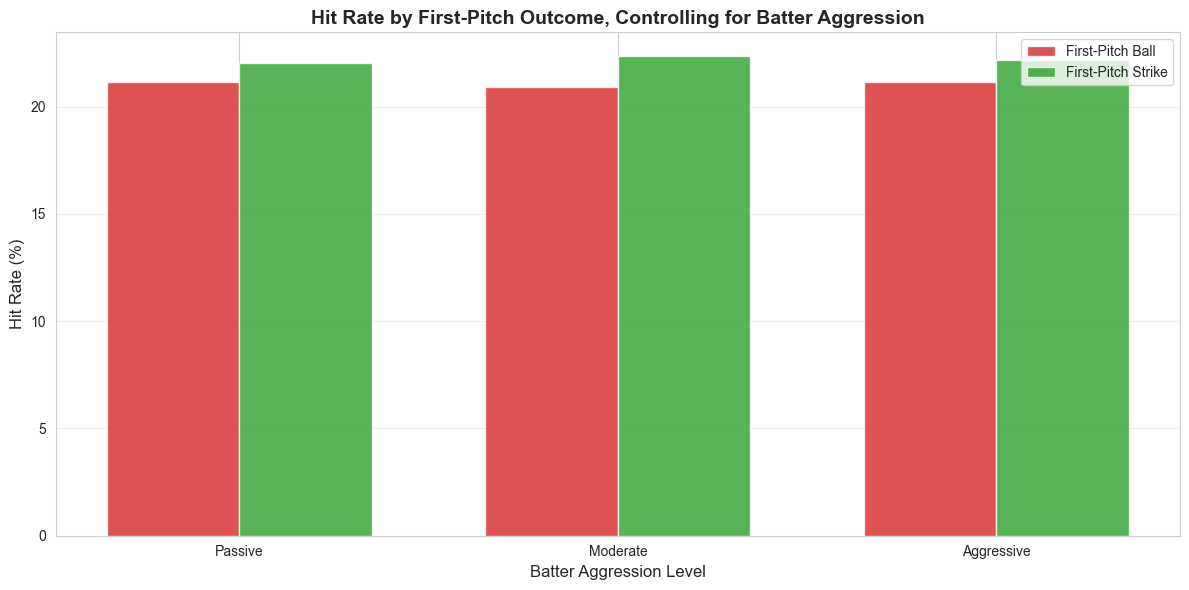

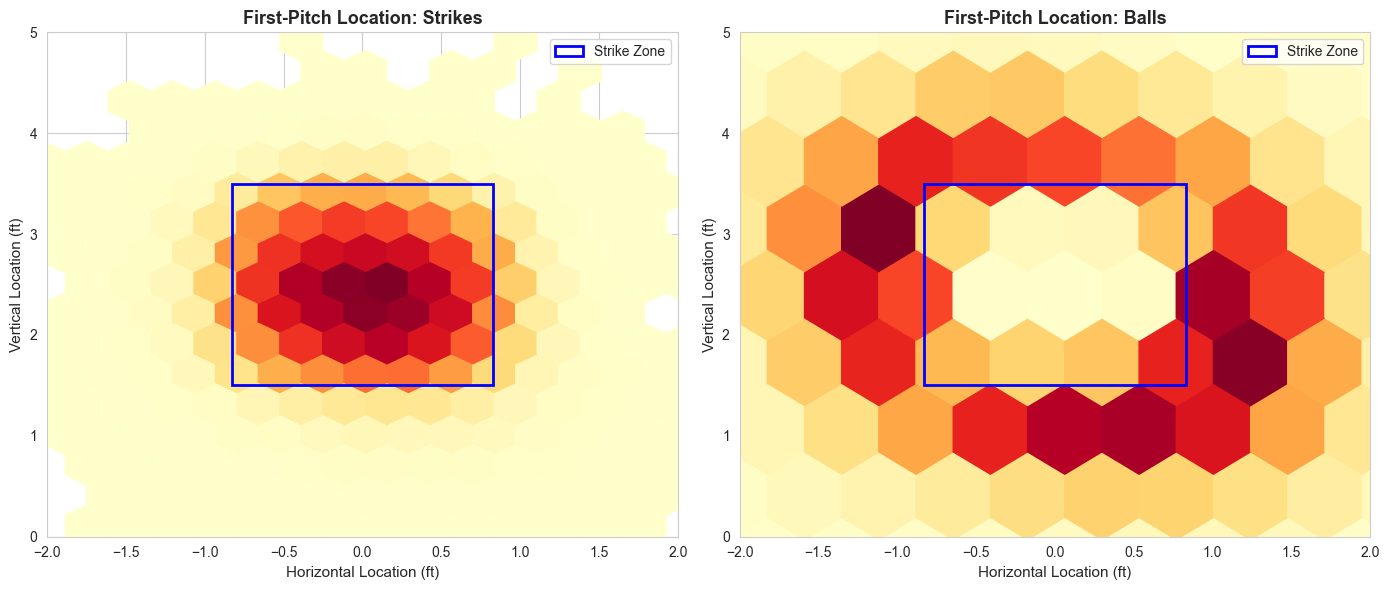

In [15]:
# STEP 5: Visualizations for Blog Post

print("\n" + "="*60)
print("Creating visualizations...")
print("="*60)

# Visualization 1: Outcome distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Counts
outcome_counts = df.groupby(['first_pitch_outcome', 'at_bat_outcome']).size().unstack(fill_value=0)
outcome_counts.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('At-Bat Outcomes by First-Pitch Type (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('First-Pitch Outcome', fontsize=12)
axes[0].set_ylabel('Number of At-Bats', fontsize=12)
axes[0].legend(title='At-Bat Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=0)

# Right plot: Percentages
outcome_by_pitch.T.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('At-Bat Outcome Rates by First-Pitch Type (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('At-Bat Outcome', fontsize=12)
axes[1].set_ylabel('Percentage', fontsize=12)
axes[1].legend(title='First Pitch', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=45, tickdir='out')

plt.tight_layout()
plt.savefig('first_pitch_outcomes.png', dpi=300, bbox_inches='tight')
print("✓ Saved: first_pitch_outcomes.png")

# Visualization 2: Aggression analysis
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate hit rates for each aggression level and first-pitch outcome
hit_rates = []
for aggression in ['Passive', 'Moderate', 'Aggressive']:
    for pitch_outcome in ['Ball', 'Strike']:
        subset = df[(df['aggression_group'] == aggression) & 
                   (df['first_pitch_outcome'] == pitch_outcome)]
        hit_rate = (subset['at_bat_outcome'] == 'Hit').mean() * 100
        hit_rates.append({
            'Aggression': aggression,
            'First_Pitch': pitch_outcome,
            'Hit_Rate': hit_rate
        })

hit_df = pd.DataFrame(hit_rates)
hit_pivot = hit_df.pivot(index='Aggression', columns='First_Pitch', values='Hit_Rate')

# Reorder to match the categorical order
hit_pivot = hit_pivot.reindex(['Passive', 'Moderate', 'Aggressive'])

x = np.arange(len(hit_pivot.index))
width = 0.35

ax.bar(x - width/2, hit_pivot['Ball'], width, label='First-Pitch Ball', alpha=0.8, color='#d62728')
ax.bar(x + width/2, hit_pivot['Strike'], width, label='First-Pitch Strike', alpha=0.8, color='#2ca02c')

ax.set_xlabel('Batter Aggression Level', fontsize=12)
ax.set_ylabel('Hit Rate (%)', fontsize=12)
ax.set_title('Hit Rate by First-Pitch Outcome, Controlling for Batter Aggression', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(hit_pivot.index)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('aggression_controlled_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: aggression_controlled_analysis.png")

# Visualization 3: Pitch location heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, pitch_type in enumerate(['Strike', 'Ball']):
    subset = df[df['first_pitch_outcome'] == pitch_type]
    
    # Create 2D histogram
    axes[idx].hexbin(
        subset['plate_x'], 
        subset['plate_z'],
        gridsize=20, 
        cmap='YlOrRd',
        mincnt=1
    )
    
    # Add strike zone rectangle
    axes[idx].add_patch(plt.Rectangle(
        (-0.83, 1.5), 1.66, 2, 
        fill=False, 
        edgecolor='blue', 
        linewidth=2,
        label='Strike Zone'
    ))
    
    axes[idx].set_xlim(-2, 2)
    axes[idx].set_ylim(0, 5)
    axes[idx].set_xlabel('Horizontal Location (ft)', fontsize=11)
    axes[idx].set_ylabel('Vertical Location (ft)', fontsize=11)
    axes[idx].set_title(f'First-Pitch Location: {pitch_type}s', 
                        fontsize=13, fontweight='bold')
    axes[idx].legend()

plt.tight_layout()
plt.savefig('pitch_location_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: pitch_location_heatmap.png")

In [16]:
# STEP 6: Summary for Blog Post

print("\n" + "="*60)
print("KEY FINDINGS FOR YOUR BLOG POST")
print("="*60)

strike_df = df[df['first_pitch_outcome'] == 'Strike']
ball_df = df[df['first_pitch_outcome'] == 'Ball']

print(f"\n1. DATASET SIZE")
print(f"   - Total at-bats analyzed: {len(df):,}")
print(f"   - First-pitch strikes: {len(strike_df):,} ({len(strike_df)/len(df)*100:.1f}%)")
print(f"   - First-pitch balls: {len(ball_df):,} ({len(ball_df)/len(df)*100:.1f}%)")

print(f"\n2. OVERALL IMPACT")
if 'Hit' in outcome_by_pitch.columns:
    strike_hit = outcome_by_pitch.loc['Strike', 'Hit']
    ball_hit = outcome_by_pitch.loc['Ball', 'Hit']
    print(f"   - Batters get hits {strike_hit:.1f}% of the time after first-pitch strikes")
    print(f"   - Batters get hits {ball_hit:.1f}% of the time after first-pitch balls")
    print(f"   - Difference: {abs(strike_hit - ball_hit):.1f} percentage points")

if 'Strikeout' in outcome_by_pitch.columns:
    strike_k = outcome_by_pitch.loc['Strike', 'Strikeout']
    ball_k = outcome_by_pitch.loc['Ball', 'Strikeout']
    print(f"   - Strikeout rate after strike: {strike_k:.1f}%")
    print(f"   - Strikeout rate after ball: {ball_k:.1f}%")

print(f"\n3. STATISTICAL SIGNIFICANCE")
print(f"   - The relationship is {'statistically significant' if p_value < 0.05 else 'not significant'}")
print(f"   - P-value: {p_value:.4f}")

print(f"\n4. BATTER AGGRESSION")
print(f"   - Mean first-pitch swing rate: {df['first_pitch_swing_rate'].mean()*100:.1f}%")
print(f"   - Aggressive batters swing at {df[df['aggression_group']=='Aggressive']['first_pitch_swing_rate'].mean()*100:.1f}% of first pitches")
print(f"   - Passive batters swing at {df[df['aggression_group']=='Passive']['first_pitch_swing_rate'].mean()*100:.1f}% of first pitches")

print("\n" + "="*60)
print("EDA COMPLETE! Use these findings in your blog post.")
print("="*60)


KEY FINDINGS FOR YOUR BLOG POST

1. DATASET SIZE
   - Total at-bats analyzed: 178,604
   - First-pitch strikes: 111,318 (62.3%)
   - First-pitch balls: 67,286 (37.7%)

2. OVERALL IMPACT
   - Batters get hits 22.2% of the time after first-pitch strikes
   - Batters get hits 21.1% of the time after first-pitch balls
   - Difference: 1.1 percentage points
   - Strikeout rate after strike: 24.9%
   - Strikeout rate after ball: 18.5%

3. STATISTICAL SIGNIFICANCE
   - The relationship is statistically significant
   - P-value: 0.0000

4. BATTER AGGRESSION
   - Mean first-pitch swing rate: 32.0%
   - Aggressive batters swing at 41.3% of first pitches
   - Passive batters swing at 22.9% of first pitches

EDA COMPLETE! Use these findings in your blog post.
